# KINTSUGI

## In the following notebook you will prepare for processing your images; test illumination correction parameters, stitching accuracy, and deconvolution.

## 1. Import packages. This must be done every time the notebook is started or restarted.

Import these packages.  Run cells using Ctrl+Enter.

In [1]:
import concurrent.futures
import gc
import os
import tkinter as tk
import errno
from tkinter import filedialog
from tkinter import simpledialog
import pandas as pd
from m2stitch import stitch_images
from basicpy import BaSiC, metrics
from glob import glob
from skimage.io.collection import alphanumeric_key
import shutil
from hyperactive import Hyperactive
import numpy as np
from skimage.io import imread 
from skimage.io import imsave
from skimage import io
from skimage import util
from skimage import exposure
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import jax
import pickle
from itertools import chain, repeat
import subprocess
import imagej, scyjava
import warnings
# warnings.filterwarnings('ignore', module='jax')
root = tk.Tk()
root.withdraw()
jax.config.update('jax_platform_name', 'cpu')

## 2. Define directory paths.  *This must be done every time the notebook is started or restarted.

If you are familiar with defining directories, enter them below.  If not the other cells will assist with the necessary definitions.

Below are two ways to get the required paths to input, output, and meta folders.  The first is where they can be entered manually.  The second assists with the process.  

Choose only one method: A or B

### 2.1 Method A

In [2]:
image_dir ="C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_raw"
stitch_dir = "C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_BaSiC_Stitched"
meta_dir = "C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_meta"
print(f"Image folder is {image_dir}.")
print(f"Stitching folder is {stitch_dir}.")
print(f"Meta folder is {meta_dir}.")

Image folder is C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_raw.
Stitching folder is C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_BaSiC_Stitched.
Meta folder is C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_meta.


### 2.1 Method B

First, assess the folder and file names.  For example, in CODEX output, the original folder name is something like CX_20-008_SP_CC2-B. We can shorten that now to make life easier down the road.  Shorten the folder name to remove redundant information.  In this example we choose "2008_CC2B_raw" making sure the '_raw' is the last part.

Running the following cell will bring up a dialog window where you will enter the new folder name and select the folder containing your images.  This folder will be renamed designated as the image_dir for the project.  An stitching output folder and a folder for metadata files will also be created.  Make sure there are only a series of folders each containing the images for each cycle in the folder you select.

In [ ]:
root = tk.Tk()
root.withdraw()

user_choice = simpledialog.askstring("Shortened name", "Enter shortened file name with _raw at end")
image_dir_long = filedialog.askdirectory()
head_dir, tail_dir = os.path.split(image_dir_long)

try:  
    os.rename(image_dir_long, os.path.join(head_dir, user_choice))
except FileNotFoundError:
    print("The file or directory does not exist.")
except PermissionError:
    print("you don't have permissions to rename the file")
except OSError as error:
    print(f"Error: {error}")

if os.path.isdir(os.path.join(head_dir, user_choice)) == True:
    image_dir = os.path.join(head_dir, user_choice)
    print(f"{image_dir_long} renamed to {image_dir}")

else:
    print("Error in renaming.")
    
stitch_dir = image_dir.replace('_raw', '_BaSiC_Stitched')
meta_dir = image_dir.replace('_raw', '_meta')
os.makedirs(stitch_dir, exist_ok=True)
os.makedirs(meta_dir, exist_ok=True)

if os.path.isdir(stitch_dir) == True:
    print(f"Stitching output folder: {stitch_dir} created successfully.")

else:
    print("Stitching output folder not created.")

if os.path.isdir(meta_dir) == True:
    print(f"Metadata folder: {meta_dir} created successfully.  Move metadata files to metadata folder.")

else:
    print("Metadata folder not created.")

In [ ]:
image_dir = filedialog.askdirectory()
stitch_dir = filedialog.askdirectory()
meta_dir = filedialog.askdirectory()

In [ ]:
print(f"Image folder is {image_dir}.")
print(f"Stitching folder is {stitch_dir}.")
print(f"Meta folder is {meta_dir}.")

Optional. Save these variables in a text file to use later.

In [ ]:
project_file = os.path.join(meta_dir, "project_data.txt")
variables = globals()
variable_names_to_save = ['stitch_dir', 'meta_dir', 'image_dir']

with open(project_file, 'w') as file:
    for var_name in variable_names_to_save:
        if var_name in variables:
            var_value = variables[var_name]
            var_str = f'{var_name}={var_value}\n'
            file.write(var_str)

### 2.3 Shorten cycle folder names

NOTE: Running this cell permanently alters the cycle folder names.  This only needs to be run once.

If the cycle folders have long names starting with the cycle numbers followed by a split character (e.g. the underscore in 'cyc001_reg001_200210_170925') this cell will shorten the folder name to everything before the first split character.

Make sure to run the codeblock above before moving on to the next code block.

Enter the split character in quotations.  It is usually an underscore.

Note that the rest of the folder name will be deleted unless you add additional arguments to the os.rename function.

In [ ]:
# Rename long source folder names

split_character = simpledialog.askstring("Split character", "Enter split character")
print(f'Split character is {split_character}.')
if split_character == 'None':
    print('No input given.')

else:
    for cyc_folder in os.listdir(image_dir):
        new_name = cyc_folder.split(split_character)
        cycle_dir = os.path.join(image_dir, cyc_folder)
        cycle_dir_short = os.path.join(image_dir, new_name[0])
        new_cycle_name = os.rename(cycle_dir, cycle_dir_short)
        if os.path.isdir(new_cycle_name) == True:
            print(f"{cycle_dir} renamed to {cycle_dir_short}")

## 3. Testing functions

Before running very large image datasets, first inspect a sample of images, and then check the quality of illumination correction, stitching, and deconvolution.  Here parameters can be tested, tuned, and refined as necessary with visual inspection of a single cycle, zplane, channel combination.  Starting with the nuclear staining channel or other channels necessary for segmentation is a good idea, then make sure to assess channels with differing staining patterns and intensities.

Make sure the directories are defined!

The zplane and channel numbers of interest, and the pattern of the image_file name must be entered below.  The wildcard characters "??" are entered where the image tile numbers are so that all tiles are loaded.

The cycle folder names are assumed to have been shortened and in the format "cyc00x".  Running the cell will prompt to enter the cycle folder of interest.
    

In [3]:
# cycle_folder = filedialog.askdirectory()
cycle_folder = "C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_raw/cyc012"

zplane = 8 
channel = 2

# image_file name below is derived from 1_000tt_Z0zz_CHc.tif where tt is the tile number with one leading zero, zz is the z-position with one leading zero, and c is the channel number.
image_file = f'1_000??_Z0{str(zplane).zfill(2)}_CH{channel}.tif'
print(f"Using {cycle_folder}/{image_file}")

#Convert to numpy array
im_raw = sorted(glob(os.path.join(cycle_folder, image_file)), key = alphanumeric_key)
im = io.imread_collection(im_raw)
im_array_init = np.asarray(im)
print(f"INITIAL  Type: {im_array_init.dtype}; Min pixel: {str(np.min(im_array_init))}; Max pixel: {str(np.max(im_array_init))}")

# im_array = exposure.rescale_intensity(im_array_init, out_range=(0, 1))

# print(f"RESCALED  Type: {im_array.dtype}; Min pixel: {str(np.min(im_array))}; Max pixel: {str(np.max(im_array))}")

Using C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_raw/cyc012/1_000??_Z008_CH2.tif
INITIAL  Type: uint16; Min pixel: 0; Max pixel: 5481


Text(0.5, 1.0, 'histogram of gray values')

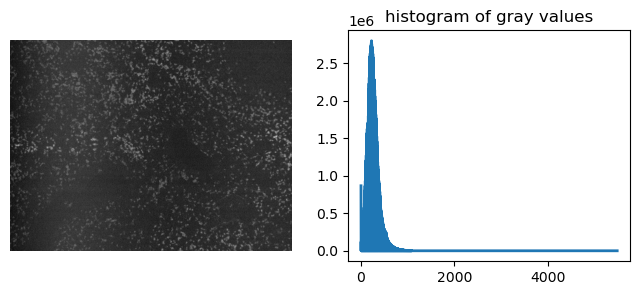

In [5]:
i = 35

hist, hist_centers = exposure.histogram(im_array_init)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(im_array_init[i], cmap=plt.cm.gray)
axes[0].set_axis_off()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')

### 3.1 Illumination Correction

For illumination correction, we use the BaSiCPy package.  An important consideration is whether or not to calculate darkfield.  There are many more arguments for the BaSiC and autotune functions that can be manipulated as needed.  For more information see: https://github.com/peng-lab/BaSiCPy/tree/main.

To reuse a set of parameters, uncomment the load_model and save_model lines while commenting out the first two lines.  

In [7]:
test_name = "12-5-2024"
model_dir_basic = os.path.join(meta_dir, test_name)
max_basic_workers = os.cpu_count()#(os.cpu_count()-(os.cpu_count()//5))  
   
basic = BaSiC(max_reweight_iterations_baseline=20, max_reweight_iterations=20, max_workers=max_basic_workers)
print(f"BaSiC is using {max_basic_workers} threads.")
basic.autotune(im_array_init, random_state=0, early_stop=False, search_space={"smoothness_flatfield": list(np.logspace(-1, 1, 10))}, init_params={"smoothness_flatfield": 0.1})
# basic = BaSiC.load_model(model_dir_basic)

# Make optional to save intermediate results
images_transformed_ff = basic.fit_transform(im_array_init)
basic.save_model(model_dir_basic, overwrite=True)

# ratio_1 = np.quantile(im_array, 0.95) / np.quantile(basic.flatfield, 0.95)
# print(f"Image quantile: {np.quantile(im_array, 0.95)} flatfield quantile: {np.quantile(basic.flatfield, 0.95)}")


BaSiC is using 32 threads.
vmin_init: 24.0 vmax_init: 679.0 val_range_init: 996.9000000000001
vmin: 27.366178302764894 vmax: 686.705322875976 val_range: 1005.4284238414756


[0] fit_and_calc_entropy (Hill Climbing):   0%|          | 0/100 [00:00<?, ?it/s]

vmin_new: 16.419706981658937 


[0] fit_and_calc_entropy (Hill Climbing):   2%|          | 2/100 [00:04<06:47,  4.15s/it, best_iter=0, best_pos=[0], best_score=-6.126066056379685]

Entropy: 6.126066056379685, Fourier L0 norm: 0
vmin_new: 16.418591297149657 


[0] fit_and_calc_entropy (Hill Climbing):   8%|          | 8/100 [00:08<04:08,  2.70s/it, best_iter=0, best_pos=[1], best_score=-6.126036045937119]

Entropy: 6.126036045937119, Fourier L0 norm: 0
vmin_new: 16.411350620269776 


[0] fit_and_calc_entropy (Hill Climbing):   9%|          | 9/100 [00:12<01:44,  1.15s/it, best_iter=0, best_pos=[2], best_score=-6.125933362072058]

Entropy: 6.125933362072058, Fourier L0 norm: 0
vmin_new: 16.350195362091064 


[0] fit_and_calc_entropy (Hill Climbing):  11%|─         | 11/100 [00:16<02:21,  1.59s/it, best_iter=0, best_pos=[2], best_score=-6.125933362072058]

Entropy: 6.1257410844549325, Fourier L0 norm: 0
vmin_new: 16.38144836425781 


[0] fit_and_calc_entropy (Hill Climbing):  14%|─         | 14/100 [00:20<02:29,  1.74s/it, best_iter=0, best_pos=[4], best_score=-6.1257410844549325]

Entropy: 6.125879218482477, Fourier L0 norm: 0
vmin_new: 16.279783515930177 


[0] fit_and_calc_entropy (Hill Climbing):  18%|─         | 18/100 [00:24<02:10,  1.59s/it, best_iter=0, best_pos=[6], best_score=-6.12502432033929]  

Entropy: 6.12502432033929, Fourier L0 norm: 0
vmin_new: 16.14136505126953 


[0] fit_and_calc_entropy (Hill Climbing):  22%|──        | 22/100 [00:28<01:45,  1.36s/it, best_iter=0, best_pos=[7], best_score=-6.124580138805283]

Entropy: 6.124580138805283, Fourier L0 norm: 0
vmin_new: 15.750883358001708 


[0] fit_and_calc_entropy (Hill Climbing):  32%|───       | 32/100 [00:33<01:24,  1.24s/it, best_iter=0, best_pos=[8], best_score=-6.123608101277742]

Entropy: 6.123608101277742, Fourier L0 norm: 0


Single-step optimization did not converge at the last reweighting step.


vmin_new: 15.605815887451172 


[0] fit_and_calc_entropy (Hill Climbing):  40%|────      | 40/100 [00:39<00:54,  1.11it/s, best_iter=0, best_pos=[9], best_score=-6.118065222092875]

Entropy: 6.118065222092875, Fourier L0 norm: 0
vmin_new: 16.324846961975098 


[0] fit_and_calc_entropy (Hill Climbing):  75%|───────   | 75/100 [00:43<00:08,  3.12it/s, best_iter=0, best_pos=[9], best_score=-6.118065222092875]

Entropy: 6.125447071891768, Fourier L0 norm: 0


[0] fit_and_calc_entropy (Hill Climbing): 100%|──────────| 100/100 [00:44<00:00,  2.27it/s, best_iter=0, best_pos=[9], best_score=-6.118065222092875]




Results: 'fit_and_calc_entropy'  
   Best score: -6.118065222092875  
   Best parameter set:
      'smoothness_flatfield' : 10.0  
   Best iteration: 0  
 
   Random seed: 0  
 
   Evaluation time   : 43.5456964969635 sec    [99.96 %]
   Optimization time : 0.015384197235107422 sec    [0.04 %]
   Iteration time    : 43.56108069419861 sec    [2.3 iter/sec]
 


Single-step optimization did not converge at the last reweighting step.


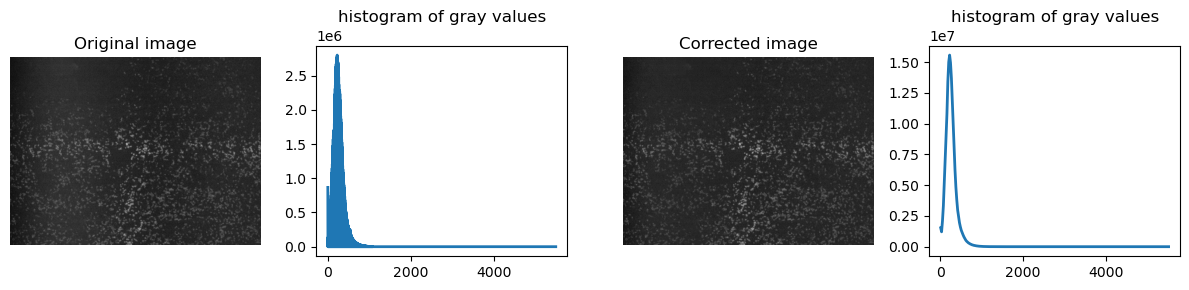

In [9]:
i = 40

hist, hist_centers = exposure.histogram(im_array_init)
hist2, hist_centers2 = exposure.histogram(images_transformed_ff)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(im_array_init[i], cmap=plt.cm.gray)
axes[0].set_title('Original image')
axes[0].set_axis_off()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')
axes[2].imshow(images_transformed_ff[i], cmap=plt.cm.gray)
axes[2].set_title('Corrected image')
axes[2].set_axis_off()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('histogram of gray values')
fig.tight_layout()

Finding the darkfield component together with the flatfield presents some computational issues in terms of memory allocation and parameter optimization.  Running illumination correction autotune to determine darkfield can be simplified by limiting the flatfield search space to the value determined above.

In [10]:
basic_2 = BaSiC(fitting_mode='approximate', get_darkfield=True, sort_intensity=True, max_workers=max_basic_workers)
basic_2.autotune(images_transformed_ff, random_state=0, histogram_bins=100, histogram_qmax=0.6, 
                        search_space={"smoothness_flatfield": [0.1],
                                    "smoothness_darkfield": list(np.logspace(-5, 1, 10)),
                                    "sparse_cost_darkfield": list(np.logspace(-5, 1, 10))},
                        init_params={"smoothness_flatfield": 0.1,
                                    "smoothness_darkfield": 1e-5,
                                    "sparse_cost_darkfield": 1e-5})                              

# basic_2=BaSiC.load_model(model_dir_basic+"_2")

images_transformed = basic_2.fit_transform(images_transformed_ff)
basic_2.save_model(model_dir_basic+"_2", overwrite=True)

vmin_init: 26.009693145751953 vmax_init: 267.6918029785156 val_range_init: 378.1289806365967
vmin: -84.90586112976074 vmax: 157.03712463378906 val_range: 311.97096196746827


[0] fit_and_calc_entropy (Hill Climbing):   0%|          | 0/100 [00:00<?, ?it/s]

vmin_new: -50.943516677856444 


[0] fit_and_calc_entropy (Hill Climbing):   1%|          | 1/100 [00:04<07:10,  4.35s/it, best_iter=0, best_pos=[0 0 0], best_score=-63.96226904860515]

Entropy: 5.661250569385398, Fourier L0 norm: 58.301018479219756
vmin_new: -50.94351200866699 


[0] fit_and_calc_entropy (Hill Climbing):   3%|          | 3/100 [00:09<07:30,  4.64s/it, best_iter=0, best_pos=[0 0 0], best_score=-63.96226904860515]

Entropy: 5.66125059827184, Fourier L0 norm: 58.303915589786506
vmin_new: -50.943521118164064 


[0] fit_and_calc_entropy (Hill Climbing):   5%|          | 5/100 [00:14<05:07,  3.24s/it, best_iter=0, best_pos=[0 0 0], best_score=-63.96226904860515]

Entropy: 5.661250519518568, Fourier L0 norm: 58.31260692148685
vmin_new: -50.86834716796875 


[0] fit_and_calc_entropy (Hill Climbing):   6%|          | 6/100 [00:18<04:30,  2.88s/it, best_iter=0, best_pos=[0 0 0], best_score=-63.96226904860515]

Entropy: 5.6609281912034435, Fourier L0 norm: 57.40544917526505
vmin_new: -51.00821228027343 


[0] fit_and_calc_entropy (Hill Climbing):   7%|          | 7/100 [00:23<05:12,  3.36s/it, best_iter=0, best_pos=[0 0 0], best_score=-63.96226904860515]

Entropy: 5.660888842874972, Fourier L0 norm: 51.447903433510575
vmin_new: -50.943544097900386 


[0] fit_and_calc_entropy (Hill Climbing):   8%|          | 8/100 [00:28<05:41,  3.71s/it, best_iter=0, best_pos=[0 0 0], best_score=-63.96226904860515]

Entropy: 5.661250542338652, Fourier L0 norm: 58.30717483917414
vmin_new: -50.94350747680664 


[0] fit_and_calc_entropy (Hill Climbing):   9%|          | 9/100 [00:33<06:02,  3.99s/it, best_iter=0, best_pos=[0 8 2], best_score=-57.10879227638555]

Entropy: 5.661250398136141, Fourier L0 norm: 58.307536977994985
vmin_new: -51.03794416809082 


[0] fit_and_calc_entropy (Hill Climbing):  11%|─         | 11/100 [00:38<06:19,  4.26s/it, best_iter=0, best_pos=[0 8 2], best_score=-57.10879227638555]

Entropy: 5.660931654943707, Fourier L0 norm: 51.620281512233774
vmin_new: -50.650593612670896 


[0] fit_and_calc_entropy (Hill Climbing):  12%|─         | 12/100 [00:42<05:01,  3.43s/it, best_iter=0, best_pos=[0 8 2], best_score=-57.10879227638555]

Entropy: 5.660168966888391, Fourier L0 norm: 35.87376130416328
vmin_new: -50.94651493835449 


[0] fit_and_calc_entropy (Hill Climbing):  13%|─         | 13/100 [00:47<05:27,  3.76s/it, best_iter=0, best_pos=[0 9 2], best_score=-41.53393027105167]

Entropy: 5.661245026909029, Fourier L0 norm: 58.17426989192329
vmin_new: -51.089561462402344 


[0] fit_and_calc_entropy (Hill Climbing):  15%|─         | 15/100 [00:52<05:44,  4.05s/it, best_iter=0, best_pos=[0 9 2], best_score=-41.53393027105167]

Entropy: 5.656789628525608, Fourier L0 norm: 34.309683736924974
vmin_new: -50.99425978088379 


[0] fit_and_calc_entropy (Hill Climbing):  19%|─         | 19/100 [00:57<04:30,  3.33s/it, best_iter=0, best_pos=[0 9 4], best_score=-39.96647336545058]

Entropy: 5.6611450973365605, Fourier L0 norm: 56.370818564105086
vmin_new: -50.777787918090816 


[0] fit_and_calc_entropy (Hill Climbing):  20%|──        | 20/100 [01:02<02:53,  2.16s/it, best_iter=0, best_pos=[0 9 4], best_score=-39.96647336545058]

Entropy: 5.659597747693016, Fourier L0 norm: 47.34668128741798
vmin_new: -50.760781860351564 


[0] fit_and_calc_entropy (Hill Climbing):  23%|──        | 23/100 [01:06<03:16,  2.56s/it, best_iter=0, best_pos=[0 9 4], best_score=-39.96647336545058]

Entropy: 5.659142613387786, Fourier L0 norm: 35.608675687303275
vmin_new: -51.20887760925293 


[0] fit_and_calc_entropy (Hill Climbing):  24%|──        | 24/100 [01:11<02:45,  2.18s/it, best_iter=0, best_pos=[0 9 4], best_score=-39.96647336545058]

Entropy: 5.656990842147241, Fourier L0 norm: 39.13373496942823
vmin_new: -50.94241369628906 


[0] fit_and_calc_entropy (Hill Climbing):  25%|──        | 25/100 [01:16<03:14,  2.60s/it, best_iter=0, best_pos=[0 9 4], best_score=-39.96647336545058]

Entropy: 5.661248528867066, Fourier L0 norm: 58.301018479219756
vmin_new: -55.37642683410644 


[0] fit_and_calc_entropy (Hill Climbing):  26%|──        | 26/100 [01:21<03:44,  3.03s/it, best_iter=0, best_pos=[0 9 4], best_score=-39.96647336545058]

Entropy: 5.646284929302357, Fourier L0 norm: 33.27215601519823
vmin_new: -50.93765281677246 


[0] fit_and_calc_entropy (Hill Climbing):  27%|──        | 27/100 [01:25<04:07,  3.40s/it, best_iter=0, best_pos=[0 9 4], best_score=-39.96647336545058]

Entropy: 5.6612350124955615, Fourier L0 norm: 58.26444245831419
vmin_new: -50.87301649475097 


[0] fit_and_calc_entropy (Hill Climbing):  29%|──        | 29/100 [01:30<04:23,  3.71s/it, best_iter=0, best_pos=[0 9 5], best_score=-38.91844094450059]

Entropy: 5.660663336271299, Fourier L0 norm: 50.641420279484265
vmin_new: -50.610845947265624 


[0] fit_and_calc_entropy (Hill Climbing):  31%|───       | 31/100 [01:35<03:39,  3.18s/it, best_iter=0, best_pos=[0 9 5], best_score=-38.91844094450059]

Entropy: 5.659892796693289, Fourier L0 norm: 51.888626378481405
vmin_new: -55.073291015624996 


[0] fit_and_calc_entropy (Hill Climbing):  34%|───       | 34/100 [01:40<03:10,  2.88s/it, best_iter=0, best_pos=[0 9 5], best_score=-38.91844094450059]

Entropy: 5.644389331066793, Fourier L0 norm: 36.99168384411805
vmin_new: -50.578294372558595 


[0] fit_and_calc_entropy (Hill Climbing):  36%|───       | 36/100 [01:44<02:27,  2.31s/it, best_iter=0, best_pos=[0 9 5], best_score=-38.91844094450059]

Entropy: 5.65996312119052, Fourier L0 norm: 53.314729054977
vmin_new: -50.94351654052734 


[0] fit_and_calc_entropy (Hill Climbing):  38%|───       | 38/100 [01:49<02:23,  2.31s/it, best_iter=0, best_pos=[0 9 5], best_score=-38.91844094450059]

Entropy: 5.661250585041572, Fourier L0 norm: 58.305002006249055
vmin_new: -50.943457077026366 


[0] fit_and_calc_entropy (Hill Climbing):  40%|────      | 40/100 [01:54<02:20,  2.35s/it, best_iter=0, best_pos=[0 9 5], best_score=-38.91844094450059]

Entropy: 5.661257436099765, Fourier L0 norm: 58.29703495219044
vmin_new: -55.07597369384765 


[0] fit_and_calc_entropy (Hill Climbing):  40%|────      | 40/100 [01:58<02:58,  2.97s/it, best_iter=0, best_pos=[0 9 5], best_score=-38.91844094450059]

Entropy: 5.644390675338703, Fourier L0 norm: 36.99675378760992


Results: 'fit_and_calc_entropy'  
   Best score: -38.91844094450059  
   Best parameter set:
      'smoothness_flatfield'  : 0.1  
      'smoothness_darkfield'  : 10.0  
      'sparse_cost_darkfield' : 0.021544346900318822  
   Best iteration: 0  
 
   Random seed: 0  
 
   Evaluation time   : 118.71697616577148 sec    [100.0 %]
   Optimization time : 0.0004382133483886719 sec    [0.0 %]
   Iteration time    : 118.71741437911987 sec    [1.19 sec/iter]
 


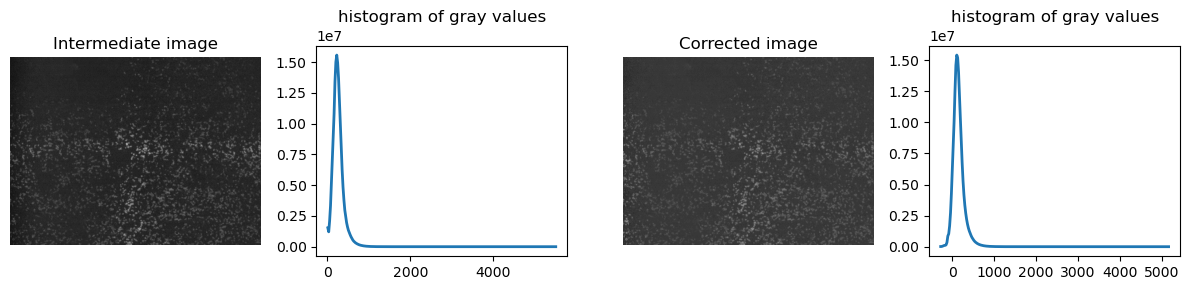

In [11]:
# Enter the tile you want to evaluate for i.
i = 40

hist, hist_centers = exposure.histogram(images_transformed_ff)
hist2, hist_centers2 = exposure.histogram(images_transformed)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(images_transformed_ff[i], cmap=plt.cm.gray)
axes[0].set_title('Intermediate image')
axes[0].set_axis_off()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')
axes[2].imshow(images_transformed[i], cmap=plt.cm.gray)
axes[2].set_title('Corrected image')
axes[2].set_axis_off()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('histogram of gray values')
fig.tight_layout()

View the correction profiles.

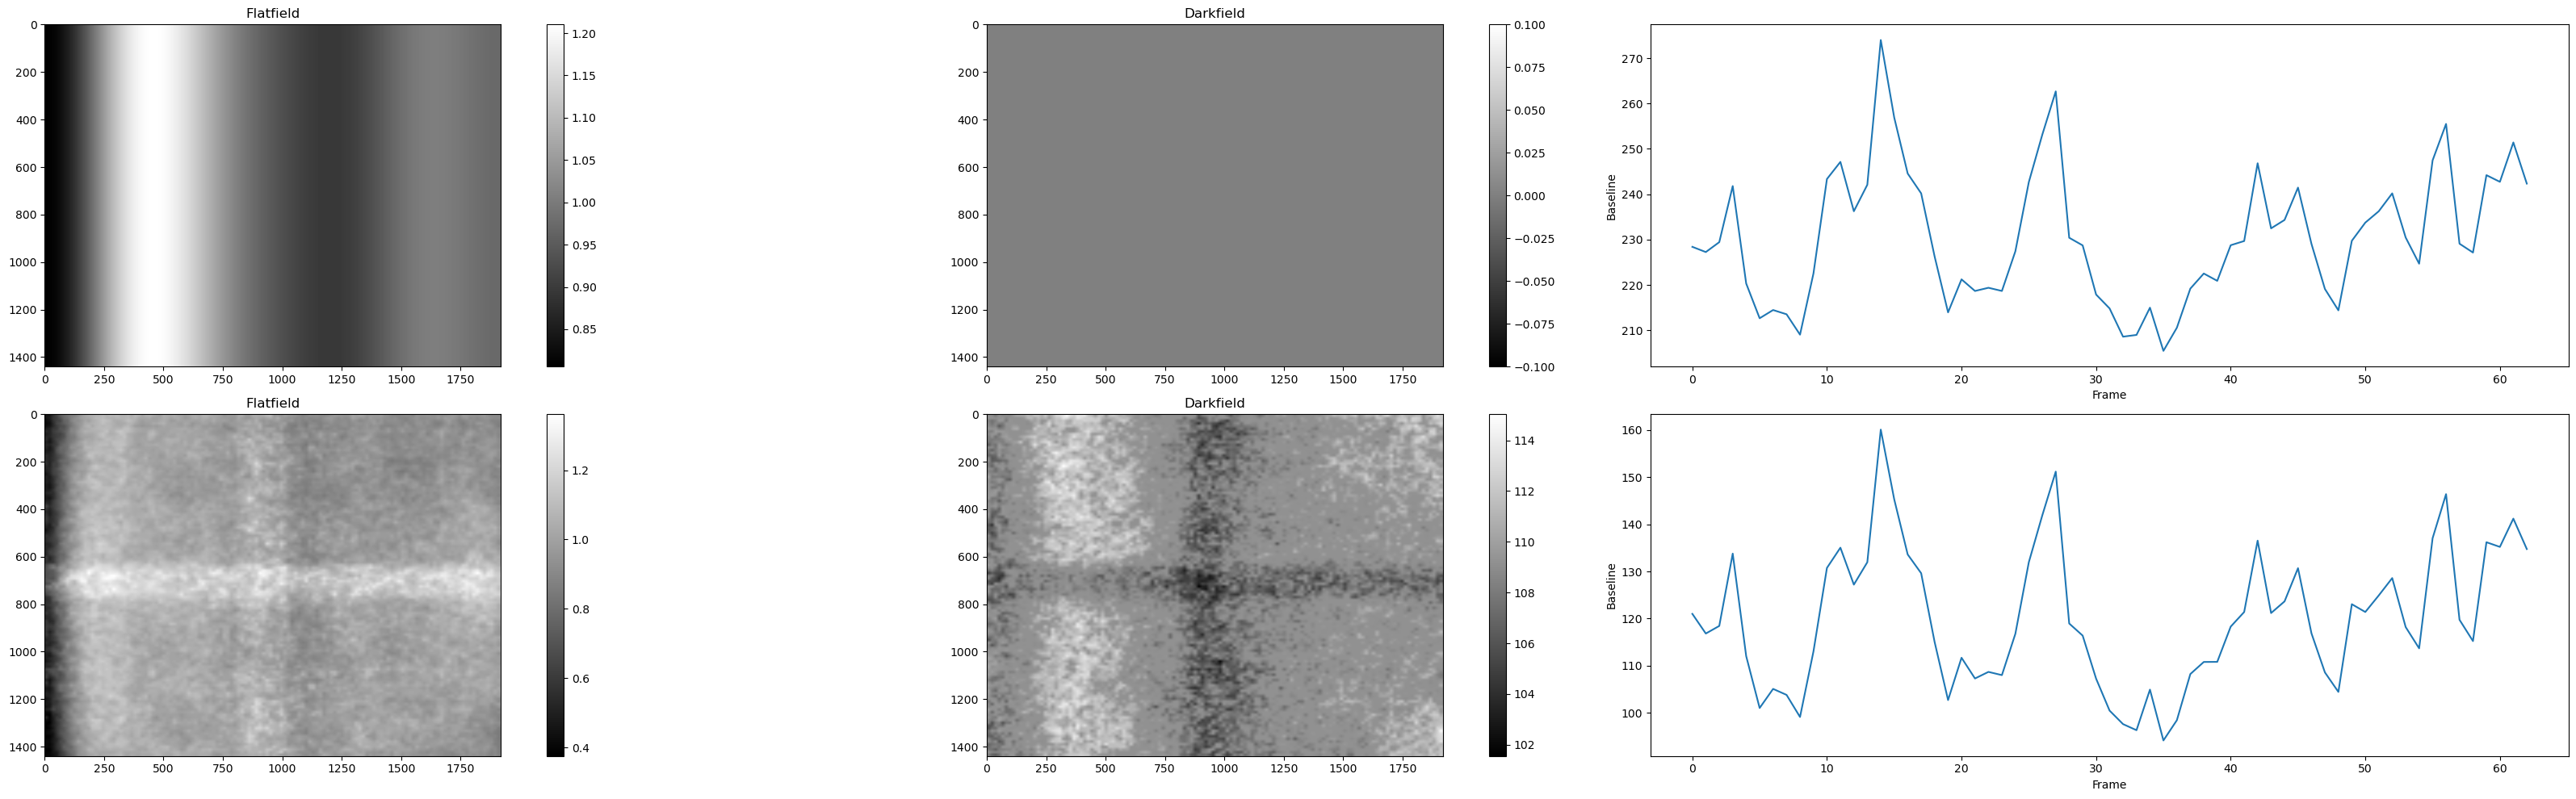

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(35, 10))
im = axes[0,0].imshow(basic.flatfield, cmap=plt.cm.gray)
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title("Flatfield")
im = axes[0,1].imshow(basic.darkfield, cmap=plt.cm.gray)
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title("Darkfield")
axes[0,2].plot(basic.baseline)
axes[0,2].set_xlabel("Frame")
axes[0,2].set_ylabel("Baseline")
im = axes[1,0].imshow(basic_2.flatfield, cmap=plt.cm.gray)
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title("Flatfield")
im = axes[1,1].imshow(basic_2.darkfield, cmap=plt.cm.gray)
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title("Darkfield")
axes[1,2].plot(basic_2.baseline)
axes[1,2].set_xlabel("Frame")
axes[1,2].set_ylabel("Baseline")
fig.tight_layout()

The middle z-plane is used to create the model that is applied to the rest of the stack.  In the next cell, use the model to test correction of a different z-plane.

In [13]:
# Check the model on another z-plane.  Enter the z-plane you want to evaluate.
zplanes = 10
cycles = 12
channels = 2
quant = 0.7


image_file_z1 = f'1_000??_Z0{str(zplanes).zfill(2)}_CH{channels}.tif'
im_raw_z1 = sorted(glob(os.path.join(cycle_folder, image_file_z1)), key = alphanumeric_key)
im_z1 = io.imread_collection(im_raw_z1)
im_array_z = np.asarray(im_z1)

basic = BaSiC.load_model(model_dir_basic)

images_transformed_ff = basic.fit_transform(im_array_z)

basic_2 = BaSiC.load_model(model_dir_basic+"_2")

images_transformed_z = basic_2.fit_transform(images_transformed_ff)


Single-step optimization did not converge at the last reweighting step.


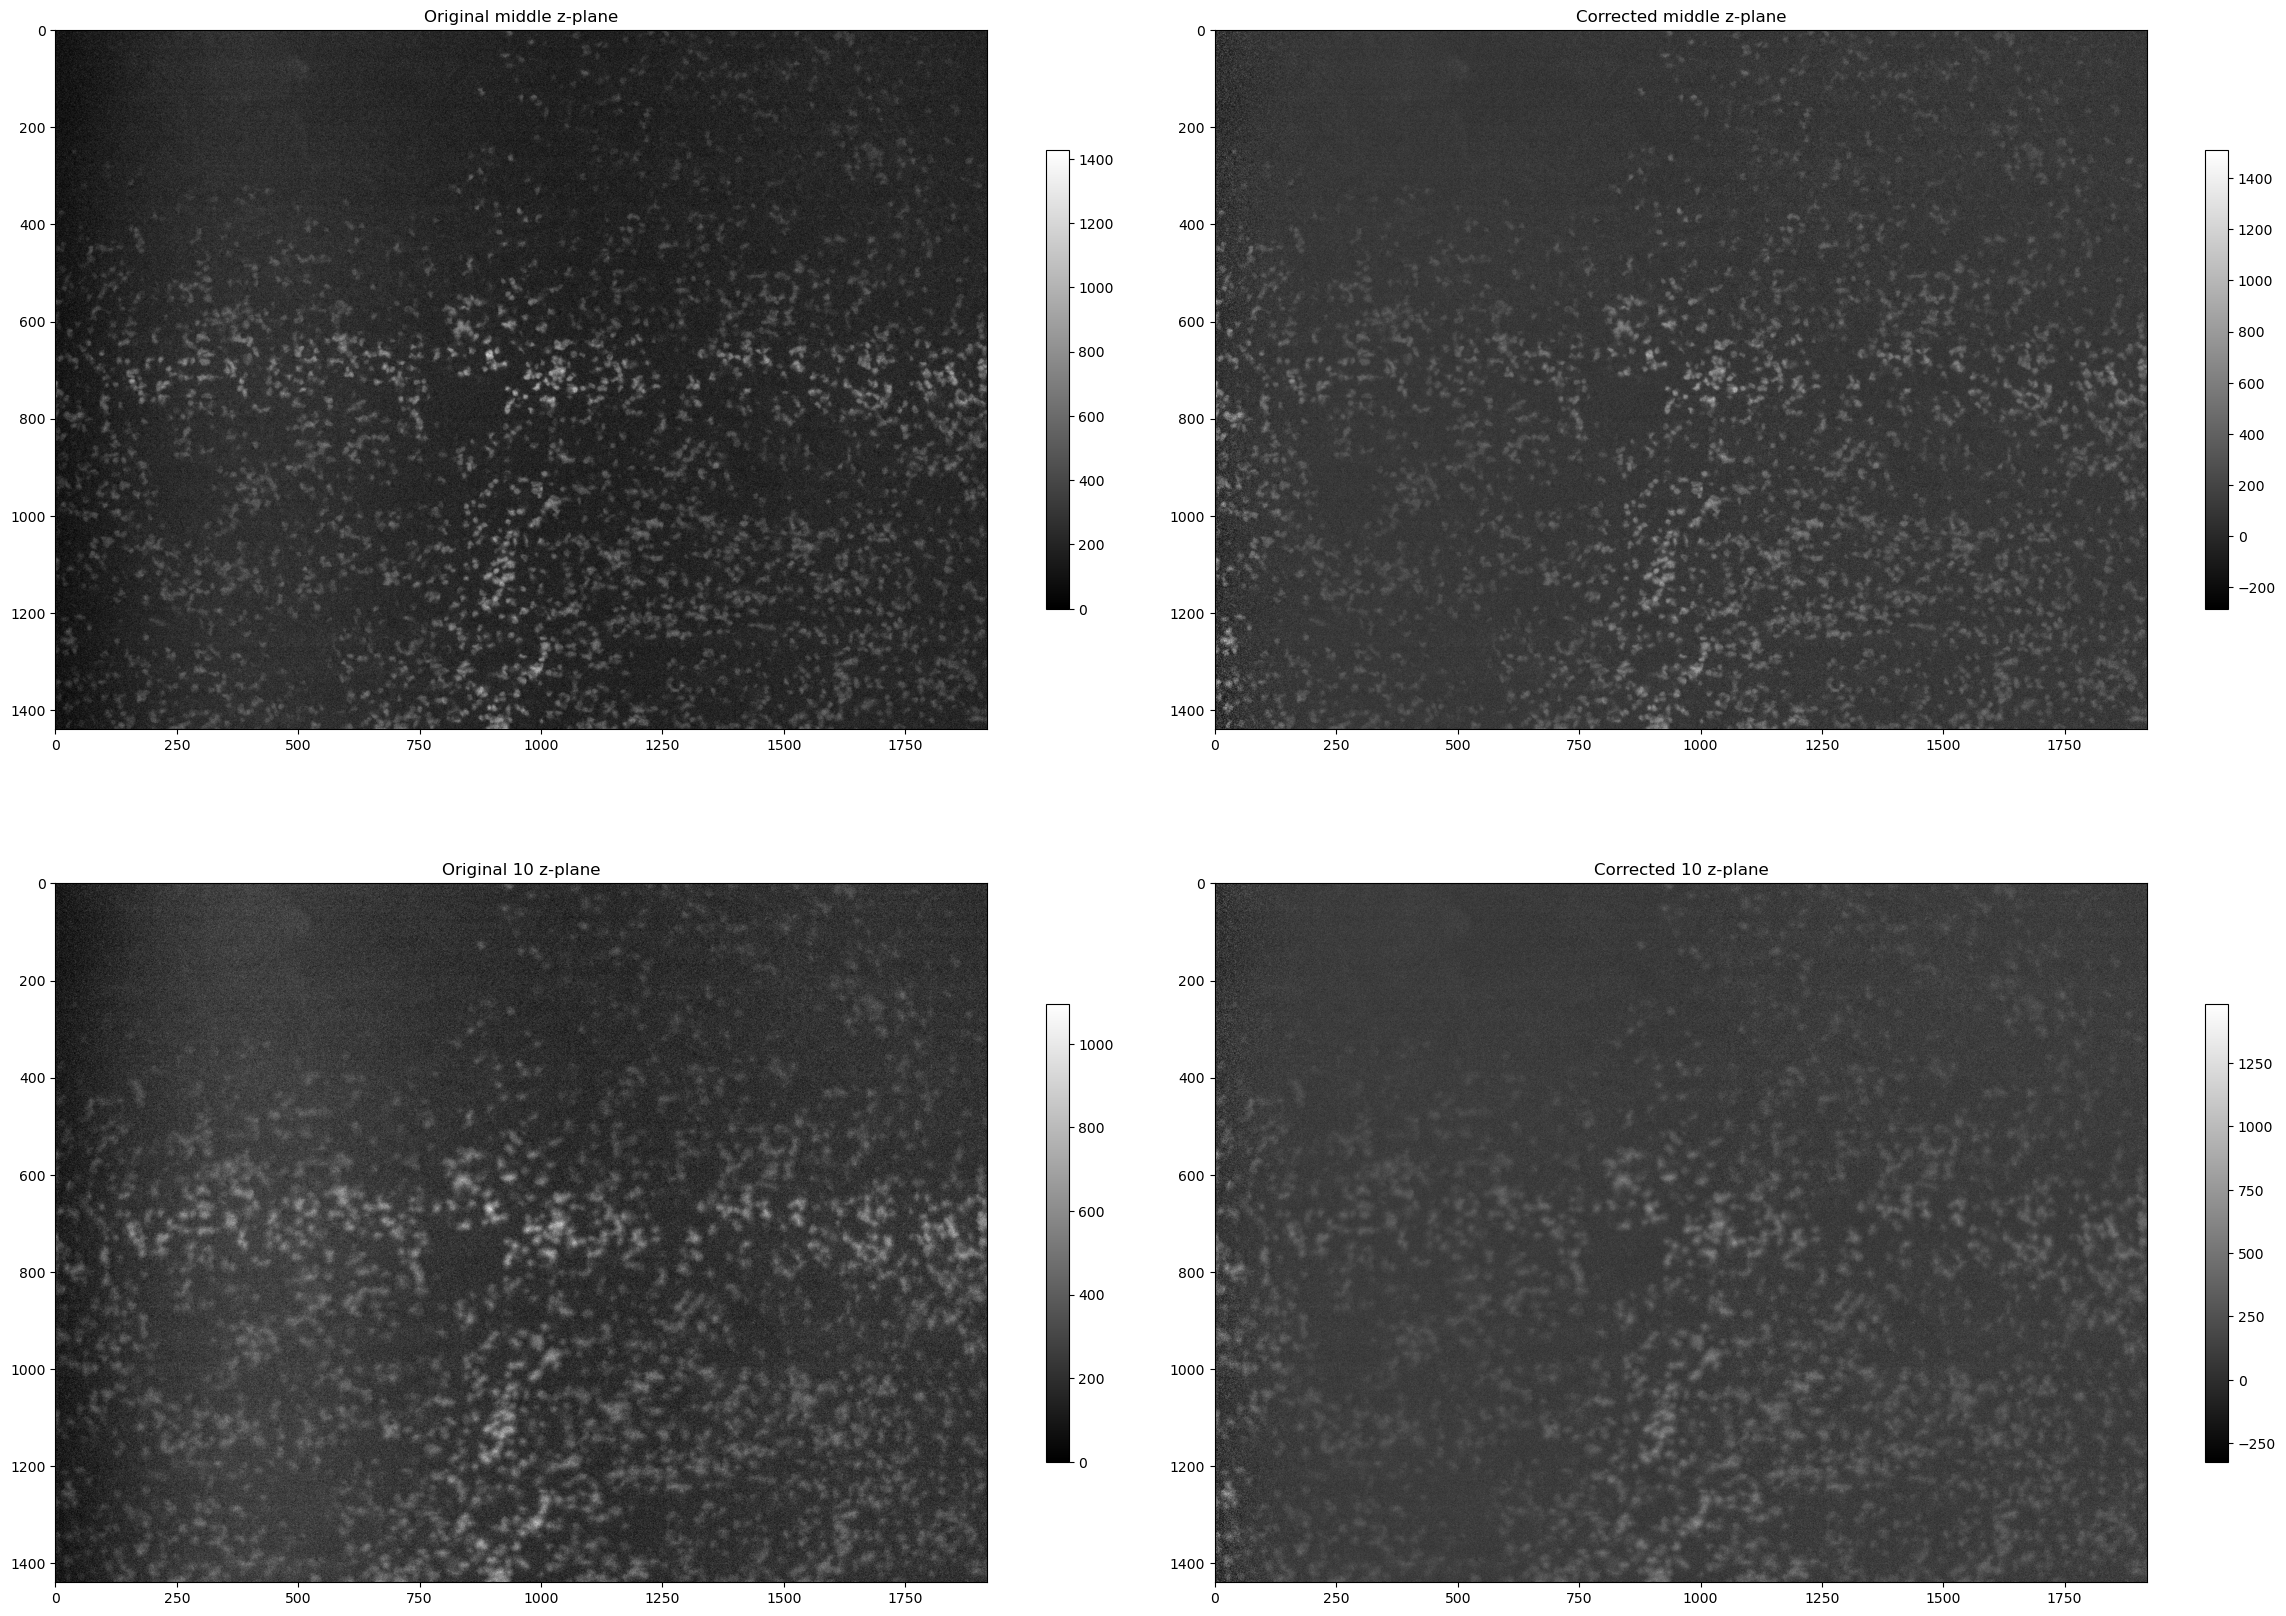

In [14]:
# Enter the tile you want to evaluate for i.
i = 40

fig, axes = plt.subplots(2, 2, figsize=(24, 18))
im = axes[0,0].imshow(im_array_init[i], cmap=plt.cm.gray)
fig.colorbar(im, shrink=0.5, ax=axes[0,0])
axes[0,0].set_title("Original middle z-plane")
im = axes[0,1].imshow(images_transformed[i], cmap=plt.cm.gray)
fig.colorbar(im, shrink=0.5, ax=axes[0,1])
axes[0,1].set_title("Corrected middle z-plane")
im = axes[1,0].imshow(im_array_z[i], cmap=plt.cm.gray)
fig.colorbar(im, shrink=0.5, ax=axes[1,0])
axes[1,0].set_title(f"Original {zplanes} z-plane")
im = axes[1,1].imshow(images_transformed_z[i], cmap=plt.cm.gray)
fig.colorbar(im, shrink=0.5, ax=axes[1,1])
axes[1,1].set_title(f"Corrected {zplanes} z-plane")
fig.tight_layout()

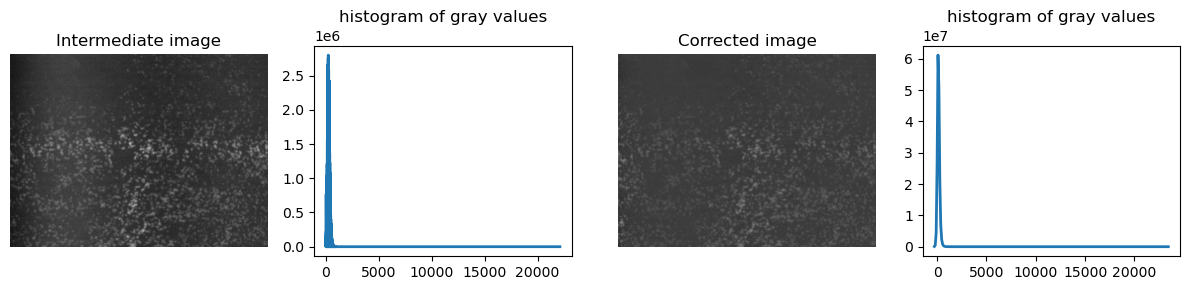

In [15]:
# Enter the tile you want to evaluate for i.
i = 40

hist, hist_centers = exposure.histogram(im_array_z)
hist2, hist_centers2 = exposure.histogram(images_transformed_z)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(im_array_z[i], cmap=plt.cm.gray)
axes[0].set_title('Intermediate image')
axes[0].set_axis_off()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')
axes[2].imshow(images_transformed_z[i], cmap=plt.cm.gray)
axes[2].set_title('Corrected image')
axes[2].set_axis_off()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('histogram of gray values')
fig.tight_layout()

## 3.2 Stitching

Here we stitch the original and corrected tiles for comparison.  This is accomplished using the package m2stitch.  Enter the number of rows and columns, and overlap percentage known from your data.  The "pou" stands for percent overlap uncertainty and is the sole parameter that can be changed to affect stitching quality.  The rows and columns functions are for generating lists corresponding to a "snake by rows" pattern starting at the upper left of the image.  They will need to be changed for other stitching patterns.

To save and reuse stitching results, uncomment/comment out the appropriate lines.  The results are saved to the metadata folder defined above.

Be sure to closely evaluate the areas of overlap for stitching quality.  The cells below allow for visualizing in this notebook and for saving to inspect elsewhere.

For more information see https://github.com/yfukai/m2stitch

In [ ]:
n = 9  # Number of rows (height)
m = 7 # Number of columns (width)
overlap_percentage = 0.30

pou = 13
stitch_model = os.path.join(meta_dir, "result.pkl")

# Row coordinates: each row index is repeated m times
rows = list(chain.from_iterable(repeat(row, m) for row in range(n)))

# Column coordinates: snake pattern for each row, going back and forth
cols = list(chain.from_iterable(
    range(m) if row % 2 == 0 else range(m - 1, -1, -1) for row in range(n)
))
result_df, _ = stitch_images(im_array, rows, cols, initial_ncc_threshold = 0, overlap_percentage=overlap_percentage, pou=pou, max_cores=10)
result_df.to_pickle(stitch_model)

If the cell above has already been run to create a stitching model, run the cell below to apply it to the original images.

In [17]:
stitch_model = os.path.join(meta_dir, "result.pkl")

result_df = pd.read_pickle(stitch_model)

result_df["y_pos2"] = result_df["y_pos"] - result_df["y_pos"].min()
result_df["x_pos2"] = result_df["x_pos"] - result_df["x_pos"].min()

size_y = im_array_z.shape[1]
size_x = im_array_z.shape[2]

stitched_image_size = (
    result_df["y_pos2"].max() + size_y,
    result_df["x_pos2"].max() + size_x,
)
stitched_image = np.zeros_like(im_array_z, shape=stitched_image_size)
for i, row in result_df.iterrows():
    stitched_image[
        row["y_pos2"] : row["y_pos2"] + size_y,
        row["x_pos2"] : row["x_pos2"] + size_x,
    ] = im_array_z[i]

Visualize the result of stitching the original tiles.

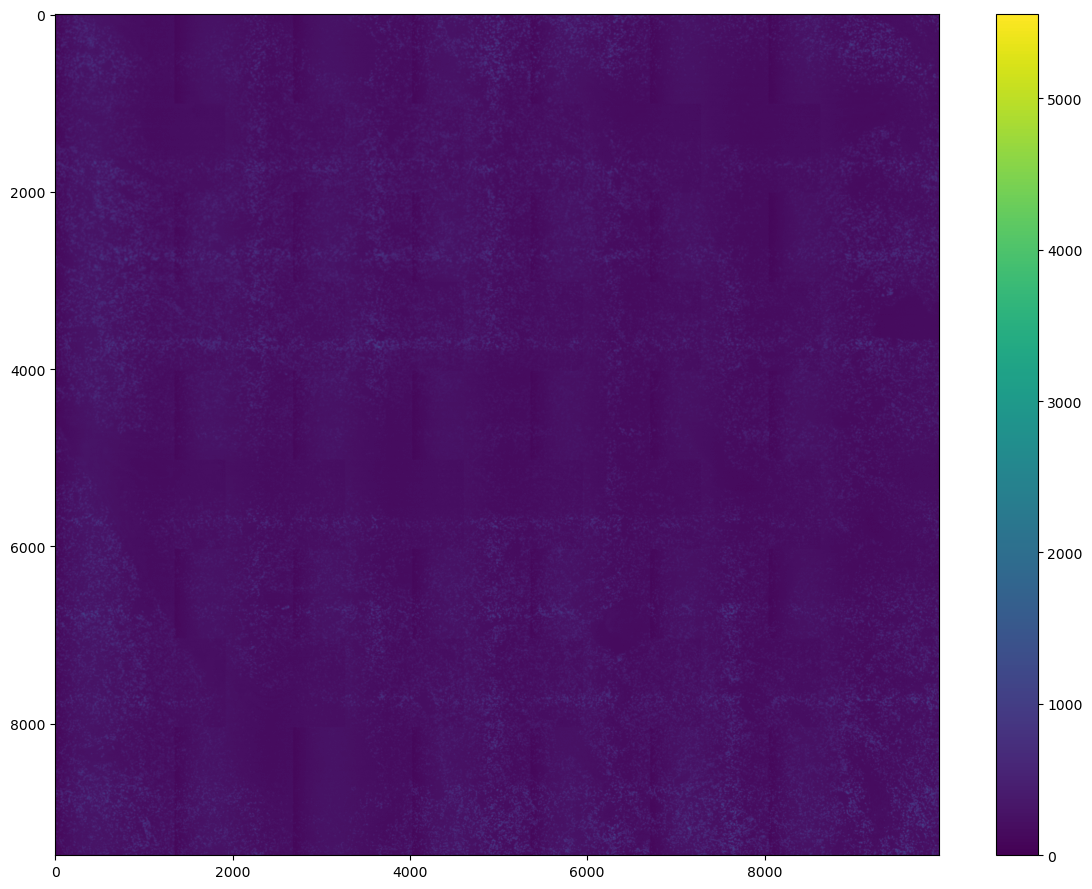

In [18]:
   
# stitched_image = stitched_image.astype(np.uint16)
# x1 = 1810
# x2 = 2050
# y1 = 1330
# y2 = 1650
fig, axes = plt.subplots(figsize=(12, 9))
im = axes.imshow(stitched_image, vmax=None)
# im = axes.imshow(stitched_image[y1:y2,x1:x2], vmax=None)
fig.colorbar(im)
fig.tight_layout()

Save the stitched image if desired.

In [ ]:

raw_image_file_path = os.path.join(meta_dir, "test_original.tif") 
imsave(raw_image_file_path, stitched_image_2)

Reuse the stitching model to stitch the corrected tiles.

In [19]:

result_df=pd.read_pickle(stitch_model)
result_df["y_pos2"] = result_df["y_pos"] - result_df["y_pos"].min()
result_df["x_pos2"] = result_df["x_pos"] - result_df["x_pos"].min()

size_y = images_transformed_z.shape[1]
size_x = images_transformed_z.shape[2]

stitched_image_size = (
    result_df["y_pos2"].max() + size_y,
    result_df["x_pos2"].max() + size_x,
)
stitched_image_basic = np.zeros_like(images_transformed_z, shape=stitched_image_size)
for i, row in result_df.iterrows():
    stitched_image_basic[
        row["y_pos2"] : row["y_pos2"] + size_y,
        row["x_pos2"] : row["x_pos2"] + size_x,
    ] = images_transformed_z[i]

Visualize the result of stitching the corrected tiles.  Comment/uncomment the coordinates to crop.

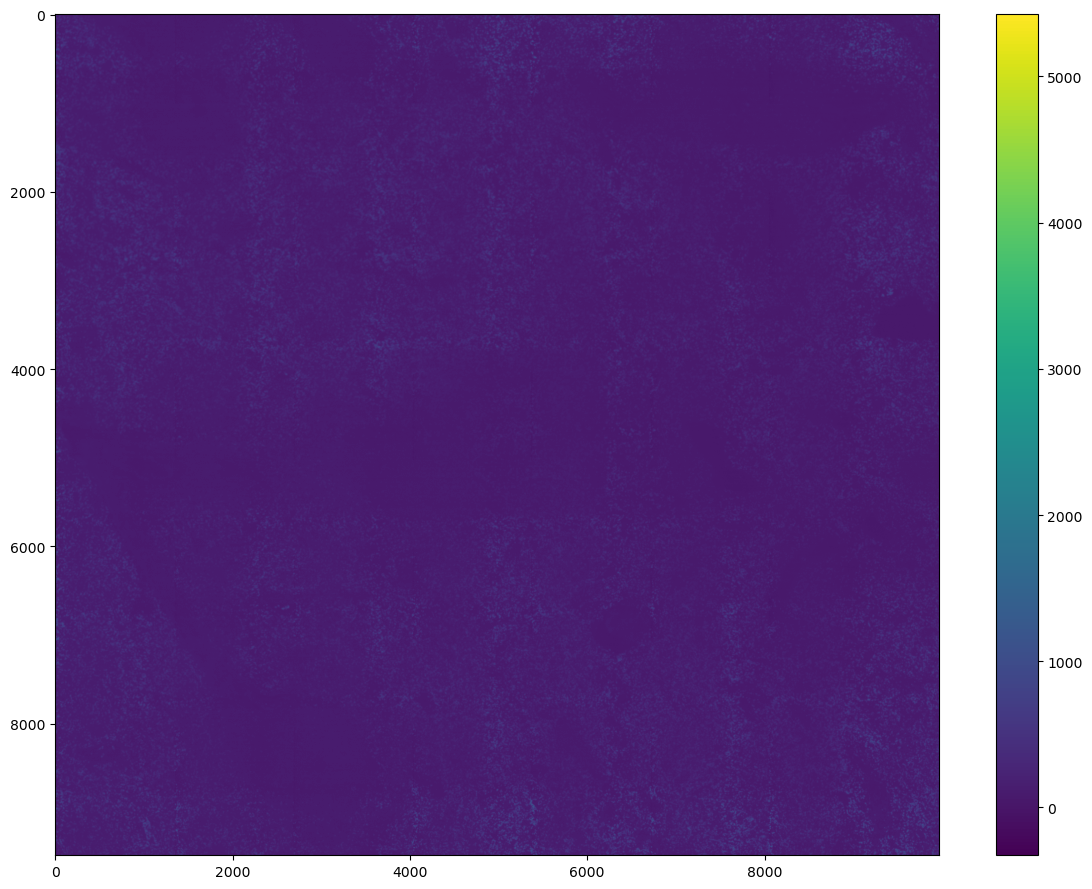

In [20]:
# x1 = 6000
# x2 = 8000
# y1 = 0000
# y2 = 3000
fig, axes = plt.subplots(figsize=(12, 9))
# im = axes.imshow(stitched_image_basic[y1:y2,x1:x2])
im = axes.imshow(stitched_image_basic, vmax=None)
fig.colorbar(im)
fig.tight_layout()

Save the corrected stitched image if desired.

In [ ]:
# stitched_image_basic_re = exposure.rescale_intensity(stitched_image_basic, in_range=(np.min(stitched_image_basic), np.max(stitched_image_basic)), out_range=(0, 65535)).astype(np.uint16)
result_image_file_path = os.path.join(meta_dir, "test_corrected.tif") 
imsave(result_image_file_path, stitched_image_basic_re, check_contrast=False)

Before testing deconvolution, you must correct and stitch an entire z-stack.  For this you can run the cells above for each image in the stack, or use B_IllumCor_Stitching_Decon.ipynb

## 3.3 Deconvolution

The following cell has multiple parameters related to the microscope used to aquire the images and the images themselves.  Once these are input, the testing is primarily to tune the number of iterations/stop_crit necessary to get good results.  The damping and hist_clip further can improve results.  There is no need to supply a point-spread function.  Finally, finding the optimal use of computing resources on GPU or CPU is accomplished via the max_GPU and max_CPU parameters.  There is no limit to image size.  If the images are too large to fit in the specified memory maximums, the will be split into blocks and processed sequentially.

Be sure the MATLAB Runtime v9.5 (R2018, 64-bit) is installed.  Download for free here: http://www.mathworks.com/products/compiler/mcr/index.html. Reboot your computer after install.  

The image_dir and stitch_dir definitions used previously will be again used here, and a new folder will be created to save the deconvolved images.  

The original deconvolution program was for lightsheet images and modified to use with widefield fluorescence.  See https://www.nature.com/articles/s41598-019-53875-y 

Output will be written to the terminal.  Check that the first image stack is processed without error.  If there is an "Maximum variable size allowed on the device is exceeded." error, then restart the kernel, decrease the max_GPU or max_CPU parameter, rerun the decon function cell, and try again.

In [ ]:
dec_cycles = 1
dec_channels = 1

# pixel size in xy dimension (nanometers)
xy_vox = 377
# pixel size in z dimension (nanometers)
z_vox = 1500
# Number of iterations of Lucy-Richardson algo before stopping unless stop_crit is met first
iterations = 25
# Microscope objective numerical aperture
mic_NA = 0.75
# Refractive index of tissue being imaged
tissue_RI = 1.3
# Opening size in millimeters of objective aperture
slit_aper = 6.5
# Focal length in millimeters of objective
f_cyl = 1
# Used to reduce noise.  Increase value for noisy images. (0-10)
damping = 0
# If set, the deconvolved images will be clipped by this percent for max and min values, and then scaled to full range of bit depth. (0-5)
hist_clip = 0.010
# Percent change between iterations to use as criteria to stop deconvolution.
stop_crit = 5.00
# Enter 1 to perform on GPU, 0 to use CPU
GPU = 1
# Percent maximum GPU memory to use if GPU = 1
max_GPU = 45
# Percent maximum RAM to use if GPU = 0
max_CPU = 20
if GPU == 1:
    max_block=max_GPU
elif GPU == 0:
    max_block=max_CPU
# The excitation and emission wavelength in nanometers
ex = 358
em = 461

decon_exe = os.path.join(os.path.dirname(image_dir), "LsDeconv.exe")
decon_dir = stitch_dir.replace('_BaSiC_Stitched', '_Decon')
source = os.path.join(stitch_dir, f"cyc{str(dec_cycles).zfill(2)}", f"CH{str(dec_channels)}")
dest = os.path.join(decon_dir, f"cyc{str(dec_cycles).zfill(2)}", f"CH{str(dec_channels)}")
os.makedirs(dest, exist_ok=True)

subprocess.run([decon_exe, source, str(xy_vox), str(z_vox), str(iterations), str(mic_NA), str(tissue_RI), str(ex), str(em), str(f_cyl), str(slit_aper), str(damping), str(hist_clip), str(stop_crit), str(max_block), str(GPU)])
gc.collect()
try:
    os.rename(os.path.join(source, 'deconvolved'), os.path.join(dest, 'deconvolved'))
except (FileNotFoundError):
    print("Reduce max memory.")

The following cell will compare the original to the deconvolved image.

In [ ]:
# Enter the cycle, channel, and z-plane for the image you want to evaluate.
c = 5
ch = 3
z = 8

# Crop the image by entering the x and y coordinates below.
x1 = 400
x2 = 1000
y1 = 600
y2 = 1200

source_image = imread(os.path.join(stitch_dir, f"cyc{str(c).zfill(2)}", f"CH{str(ch)}", f"{str(z).zfill(2)}.tif"))
dest = os.path.join(stitch_dir.replace('_BaSiC_Stitched', '_Decon'), f"cyc{str(c).zfill(2)}", f"CH{str(ch)}")
fig, axes = plt.subplots(1, 2, figsize=(24, 18))
im = axes[0].imshow(source_image[x1:x2,y1:y2])
fig.colorbar(im, shrink=0.5, ax=axes[0])
axes[0].set_title("Original")
decon_image = imread(os.path.join(dest, 'deconvolved', f"deconv_0000{str(z).zfill(2)}.tif"))
im = axes[1].imshow(decon_image[x1:x2,y1:y2])
fig.colorbar(im, shrink=0.5, ax=axes[1])
axes[1].set_title("Deconvolved")
fig.tight_layout()

You may now use the optimized parameters in the next notebook to process large datasets.

## 4 FIJI Clij2 plugin - EDF

The following section connects this notebook with a local installation of FIJI and a Clij2 plugin to run an Extended Depth of Focus (EDF) projection along the deconvolved image stack.  The image calculation is done on the GPU for efficient processing.  In the next cell enter the amount of memory (no more than 80% of system RAM is a good rule of thumb) to allow for the computation.  Also, enter the name of the GPU, and the parameters for the EDF calculation.  A new folder will be created for the results, and the image can be inspected in another program and in the next section.

### 4.1 EDF on GPU

In [ ]:
ij_mem = 40
edf_cycles = 1
edf_channels = 1
GPU_name = "NVIDIA RTX A4500"
radius_x = 5.0
radius_y = 5.0
sigma = 20.0

scyjava.config.add_option(f'-Xmx{str(ij_mem)}g')
ij = imagej.init('C:/Users/smith6jt/Fiji.app')

macro = """
#@ File in_folder
#@ String device
#@ File out_folder
#@ Integer radius_x
#@ Integer radius_y
#@ Integer sigma

File.openSequence(in_folder);
run("CLIJ2 Macro Extensions", "cl_device=[" + device + "]");
Ext.CLIJ_clear();
image1 = "deconvolved";
Ext.CLIJ2_push(image1);
image2 = "extended_depth_of_focus_variance_projection";
radius_x = 5.0;
radius_y = 5.0;
sigma = 20.0;
Ext.CLIJ2_extendedDepthOfFocusVarianceProjection(image1, image2, radius_x, radius_y, sigma);
Ext.CLIJ2_pull(image2);
selectImage(image1);
close();
selectImage(image2);
saveAs("Tiff", out_folder + File.separator + "EDF.tif");
"""
decon_dir = stitch_dir.replace('_BaSiC_Stitched', '_Decon')
edf_dir = decon_dir.replace('_Decon', '_EDF')
edf_source = os.path.join(decon_dir, f"cyc{str(edf_cycles).zfill(2)}", f"CH{str(edf_channels)}", "deconvolved")
edf_dest = os.path.join(edf_dir, f"cyc{str(edf_cycles).zfill(2)}", f"CH{str(edf_channels)}")
os.makedirs(edf_dest, exist_ok=True)

args ={'in_folder': edf_source, "cl_device" : GPU_name, "out_folder" : edf_dest, "radius_x" : 5.0, "radius_y" : 5.0, "sigma" : 20.0}
ij.py.run_macro(macro, args)

### 4.2 EDF comparison with deconvolution images

Visualize the results with periodic z-planes.

In [ ]:
decon_stack = sorted(glob(os.path.join(edf_source, f"deconv_0000??.tif")), key=alphanumeric_key)
decon_stack = io.imread_collection(decon_stack)
decon_image = np.asarray(decon_stack)
edf_result = imread(os.path.join(edf_dest, "EDF.tif"))

x1 = 2400
x2 = 3000
y1 = 2000
y2 = 3000

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
im = axes[0,0].imshow(decon_image[6][x1:x2,y1:y2])
axes[0,0].set_title("decon_z007")
im = axes[0,1].imshow(decon_image[7][x1:x2,y1:y2])
axes[0,1].set_title("decon_z008")
im = axes[0,2].imshow(decon_image[8][x1:x2,y1:y2])
axes[0,2].set_title("decon_z009")
im = axes[1,0].imshow(decon_image[9][x1:x2,y1:y2])
axes[1,0].set_title("decon_z010")
im = axes[1,1].imshow(decon_image[10][x1:x2,y1:y2])
axes[1,1].set_title("decon_z011")
im = axes[1,2].imshow(edf_result[x1:x2,y1:y2])
axes[1,2].set_title("EDF_var_x5y5_sigma20")
fig.tight_layout()

Visualize the results as a full image.

In [ ]:
edf_result = imread(os.path.join(edf_dest, "EDF.tif"))
fig, axes = plt.subplots(figsize=(24, 18))
im = axes.imshow(edf_result)
fig.colorbar(im)
fig.tight_layout()